In [1]:
import numpy as np
import cv2           
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
from scipy.spatial.distance import cdist
%matplotlib notebook

FIGSIZE = (10,8)

In [2]:
def cluster_values(values, threshold):
    values = np.array(values).reshape(-1, 1)
    # Use cdist to calculate pairwise distances
    distances = cdist(values, values)
    # Create an adjacency matrix based on the threshold
    adjacency_matrix = distances < threshold
    
    # Initialize clusters
    clusters = []
    # Iterate through each value
    for i in range(len(values)):
        found_cluster = False
        # Check existing clusters
        for cluster in clusters:
            if any(adjacency_matrix[i, c] for c in cluster):
                cluster.append(i)
                found_cluster = True
                break
        # If the value doesn't belong to any existing cluster, create a new cluster
        if not found_cluster:
            clusters.append([i])
    # Convert indices to values
    clustered_values = [[values[i][0] for i in cluster] for cluster in clusters]
    return clustered_values


def draw_grid_on_image(image, dx, dy):
    fig = plt.figure(figsize=FIGSIZE)
    plt.imshow(image, cmap='gray')

    # Add vertical grid lines
    for i in np.arange(dx, image.shape[0], dx):
        plt.axhline(i, color='red', linestyle='--', linewidth=1)

    # Add horizontal grid lines
    for j in np.arange(dy, image.shape[1], dy):
        plt.axvline(j, color='red', linestyle='--', linewidth=1)

    plt.scatter(image.shape[0] // 2, image.shape[1] // 2, color='blue', marker='o', s=50)
    plt.show()

def display(img, show_original=False):
    plt.figure(figsize=FIGSIZE)
    
    if show_original:
        plt.subplot(1, 2, 1)
        plt.imshow(im, cmap='gray')
        plt.title("Orignal")
        plt.subplot(1, 2, 2)
    
    plt.imshow(img, cmap='gray')
    plt.title("Current Image")

    plt.show()
    
def histogram(img):
    hist, bins = np.histogram(img, bins=256)

    plt.figure(figsize=FIGSIZE)
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.subplot(1,2,2)
    plt.bar(bins[:-1], hist)
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


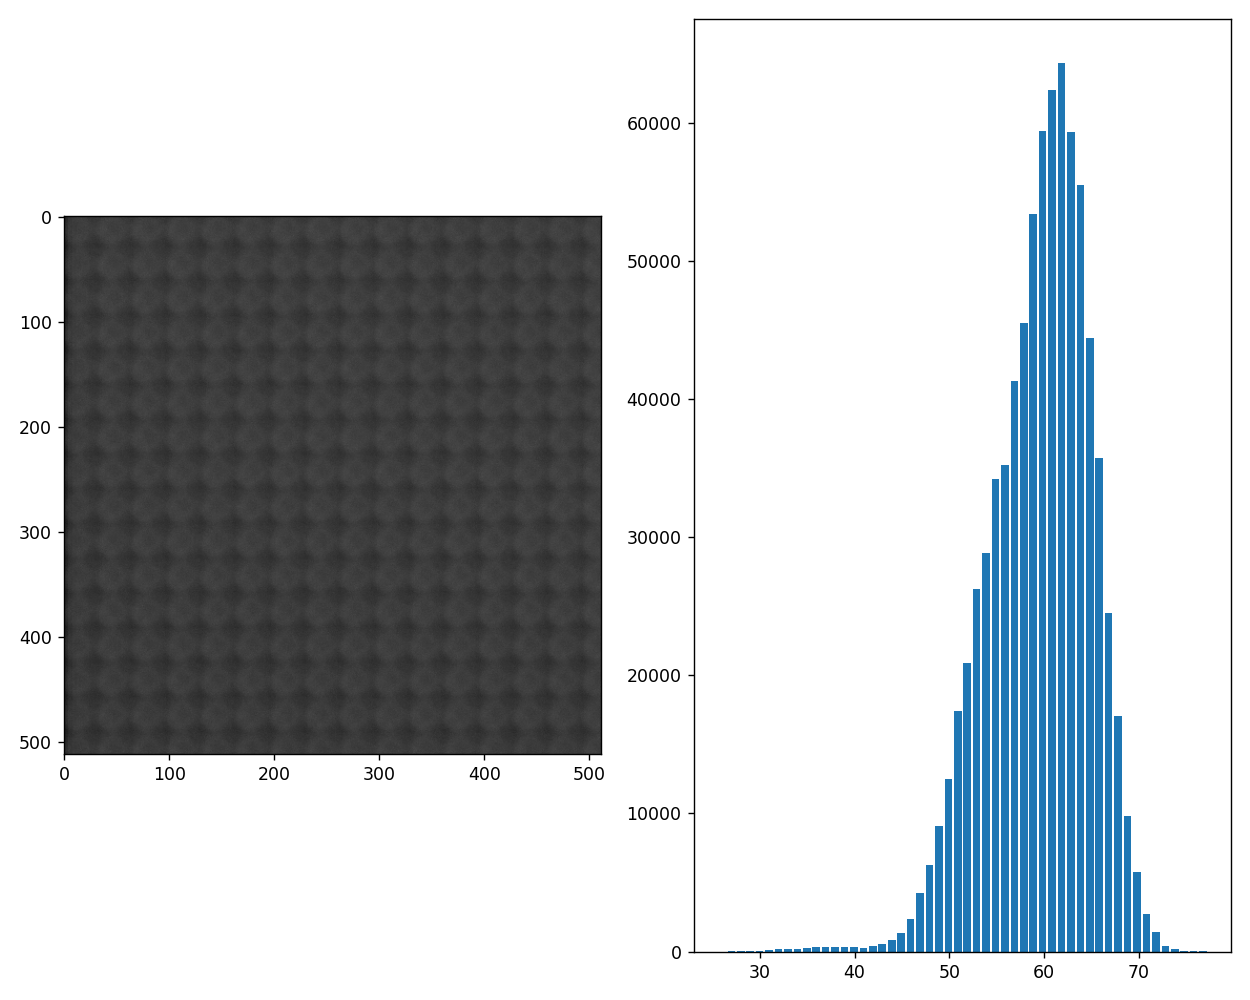

In [3]:
im = cv2.imread(r"../img/nice_mla_cercles_low.png")
histogram(im)

# Hough Transform Method

<IPython.core.display.Javascript object>


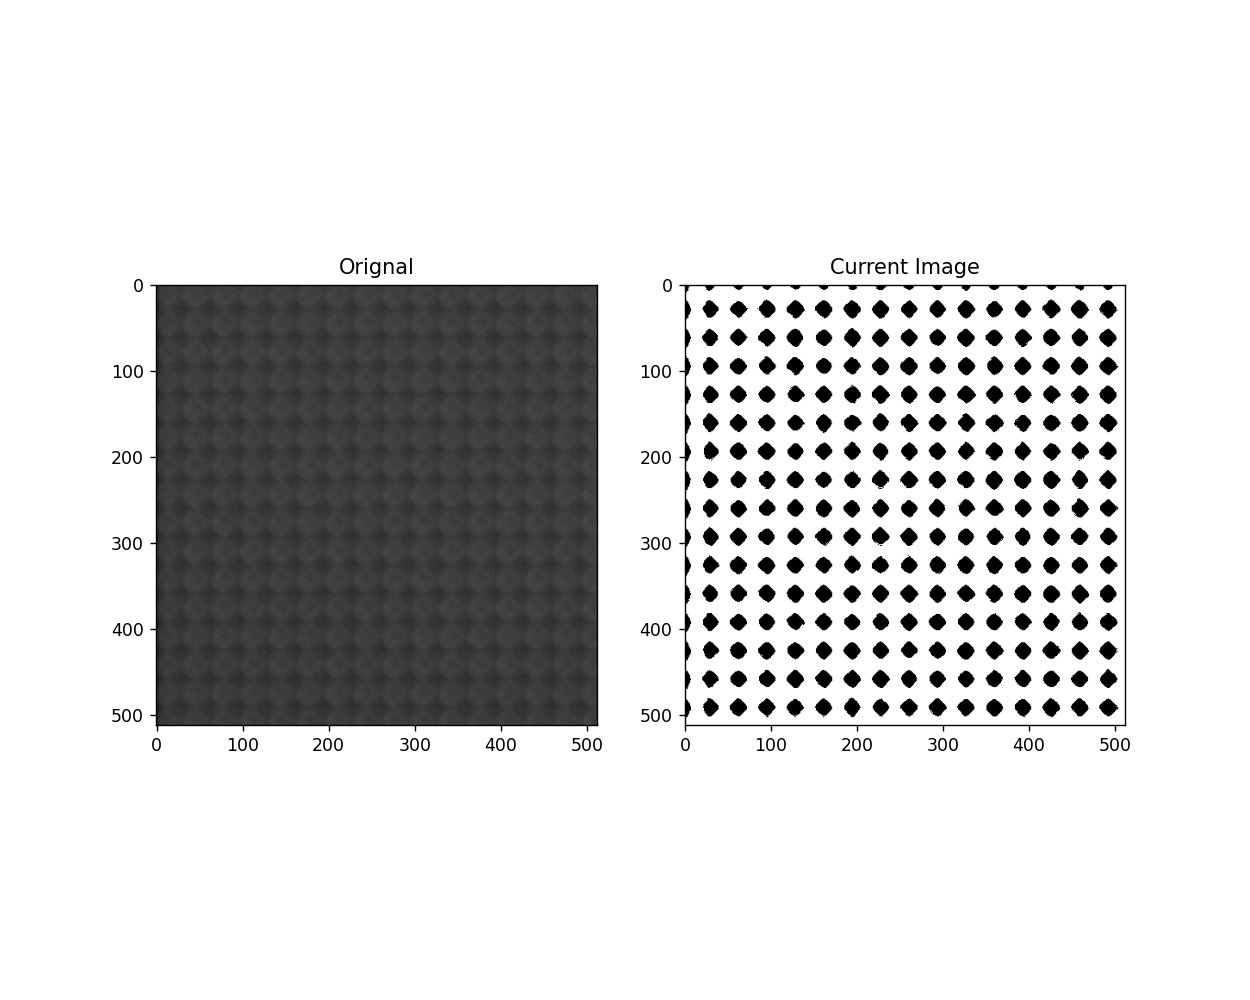

<IPython.core.display.Javascript object>


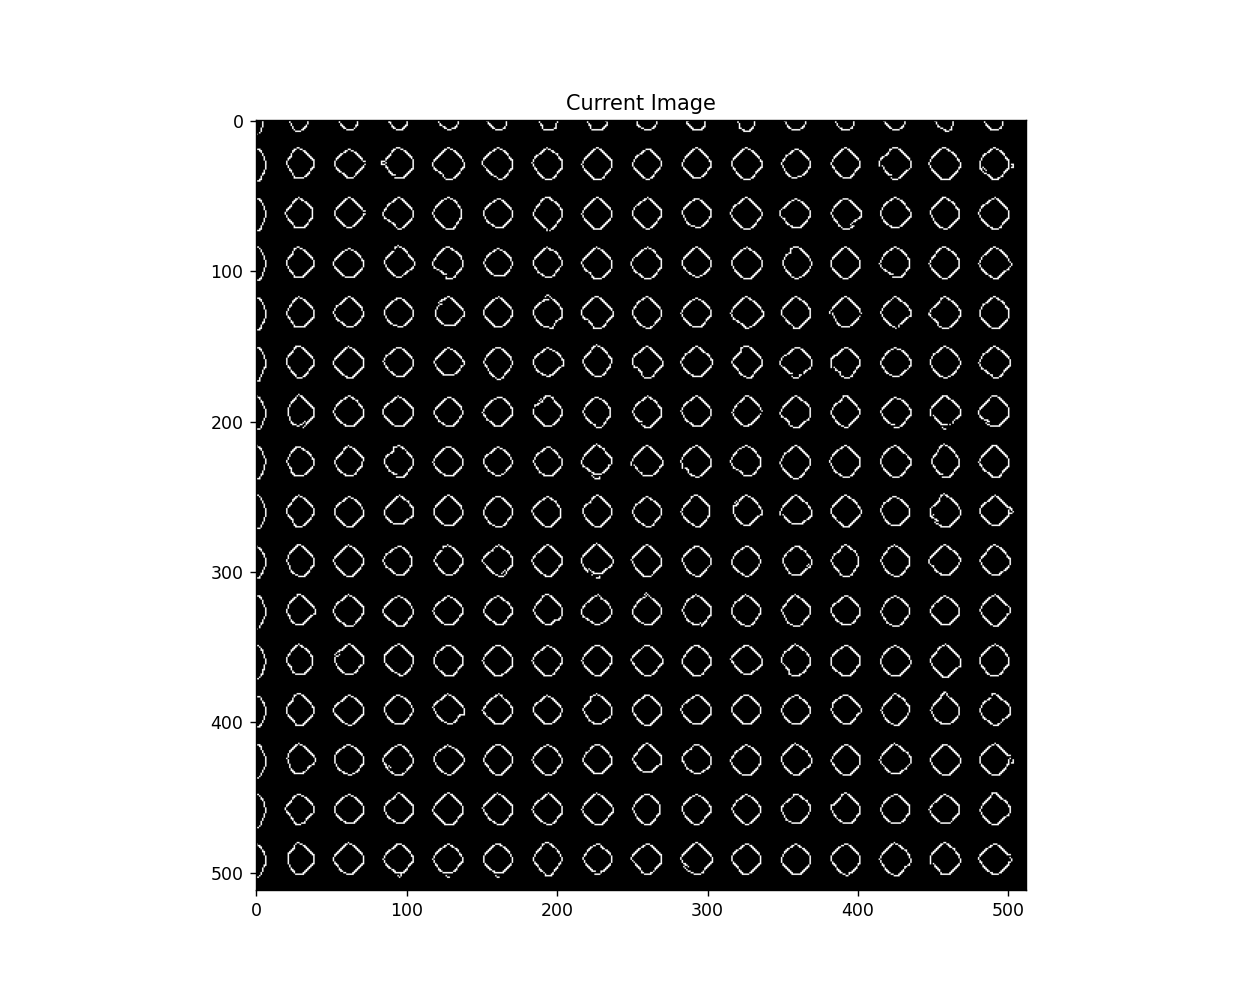

<IPython.core.display.Javascript object>


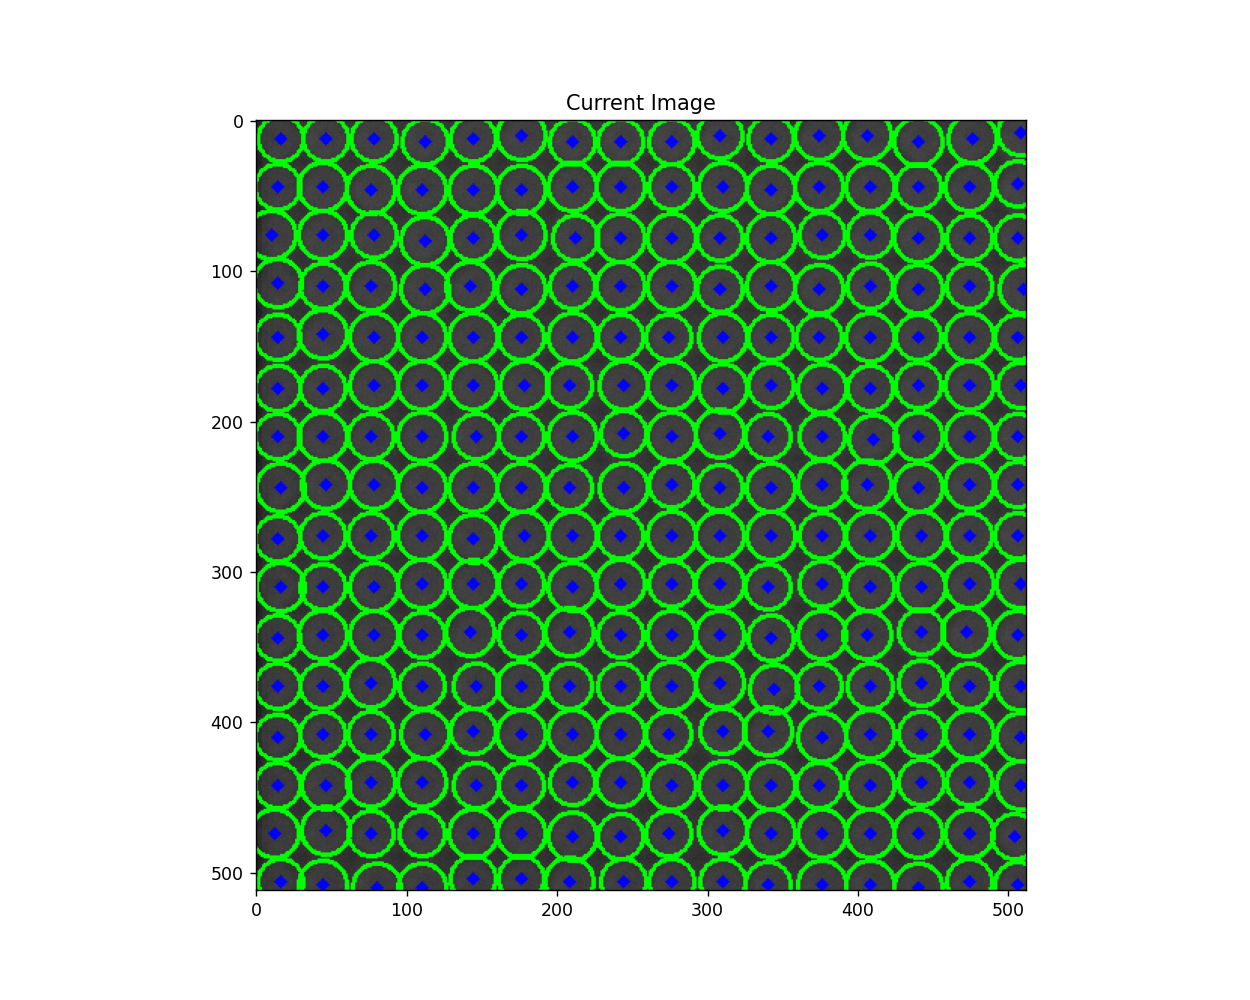

<IPython.core.display.Javascript object>


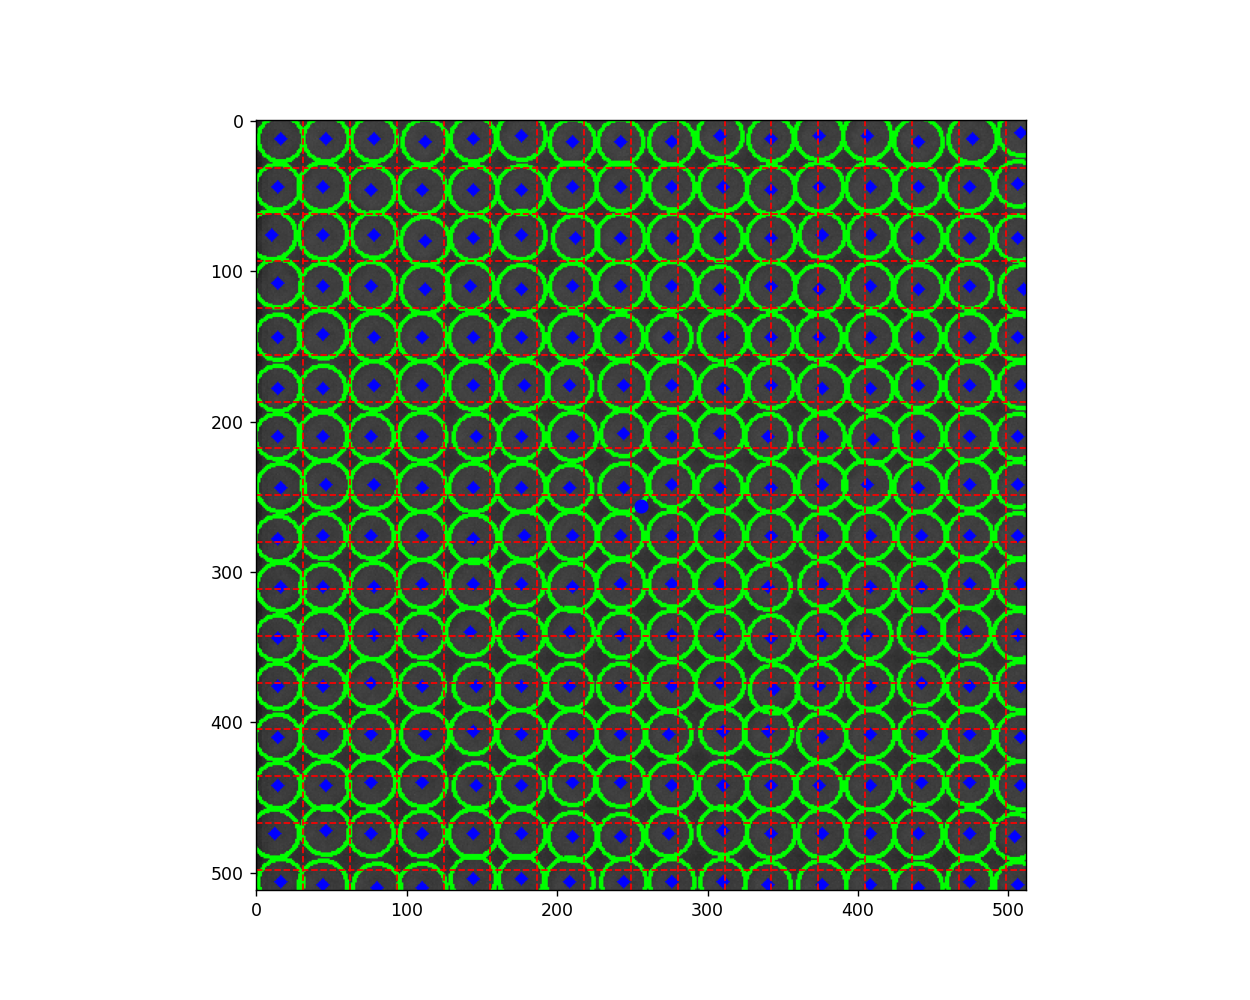

Number of circles: 256
Mean Radius: 15.56640625


In [4]:
gray = im[:,:,0]
gray = cv2.GaussianBlur(gray, (15, 15), 0)

thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 3)

edges = cv2.Canny(thresh, 50, 150)

# Use Hough Circle Transform to detect circles
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=29, param1=1, param2=1, minRadius=14, maxRadius=17)

result = im.copy()
# Convert circle coordinates to integers
if circles is not None:
    circles = np.uint16(np.around(circles))

    # Draw circles on the original image
    for i in circles[0, :]:
        # Draw the outer circle
        cv2.circle(result, (i[0], i[1]), i[2], (0, 255, 0), 2)
        # Draw the center of the circle
        cv2.circle(result, (i[0], i[1]), 2, (0, 0, 255), 3)

radius_mean = np.mean(circles[0][:,2])

display(thresh, True)
display(edges)
display(result)
draw_grid_on_image(result, radius_mean*2, radius_mean*2)
print("Number of circles:", len(circles[0]))
print(f"Mean Radius: {radius_mean}")

<IPython.core.display.Javascript object>


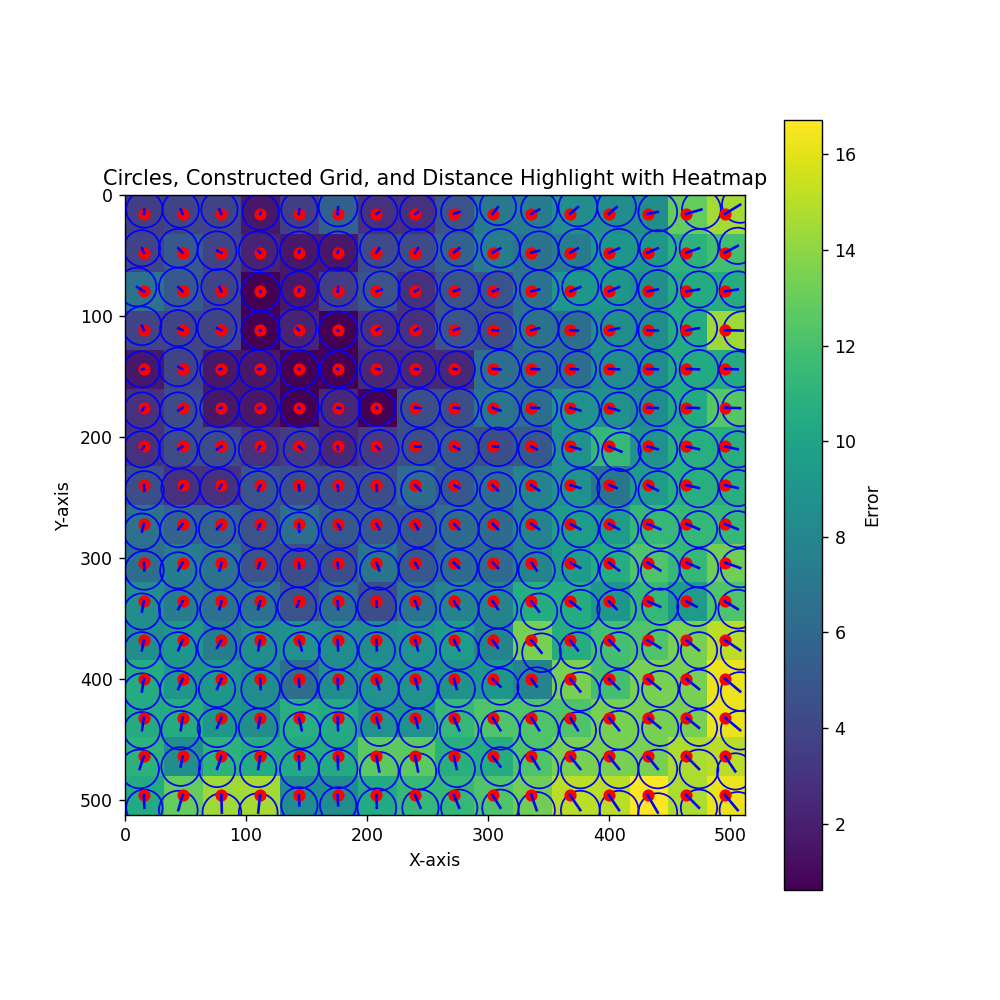

Errors:
Circle 1: 6.88 pixels
Circle 2: 12.26 pixels
Circle 3: 13.42 pixels
Circle 4: 11.34 pixels
Circle 5: 0.61 pixels
Circle 6: 6.45 pixels
Circle 7: 13.42 pixels
Circle 8: 5.06 pixels
Circle 9: 8.78 pixels
Circle 10: 11.34 pixels
Circle 11: 8.44 pixels
Circle 12: 6.62 pixels
Circle 13: 13.42 pixels
Circle 14: 14.76 pixels
Circle 15: 5.69 pixels
Circle 16: 5.06 pixels
Circle 17: 7.81 pixels
Circle 18: 6.62 pixels
Circle 19: 6.62 pixels
Circle 20: 10.61 pixels
Circle 21: 13.42 pixels
Circle 22: 8.78 pixels
Circle 23: 11.34 pixels
Circle 24: 10.71 pixels
Circle 25: 6.62 pixels
Circle 26: 4.45 pixels
Circle 27: 10.44 pixels
Circle 28: 3.44 pixels
Circle 29: 9.53 pixels
Circle 30: 7.81 pixels
Circle 31: 6.45 pixels
Circle 32: 9.16 pixels
Circle 33: 9.53 pixels
Circle 34: 11.93 pixels
Circle 35: 8.58 pixels
Circle 36: 10.71 pixels
Circle 37: 2.47 pixels
Circle 38: 12.26 pixels
Circle 39: 6.88 pixels
Circle 40: 7.36 pixels
Circle 41: 8.58 pixels
Circle 42: 1.63 pixels
Circle 43: 2.89 pixe

In [5]:
# Assuming circles is your list of circles with x, y, r coordinates
c = circles[0]
mean_diameter = radius_mean * 2

# Construct a grid based on mean diameter
grid_size = int(np.sqrt(len(c)))  # Assuming a square grid
grid_step = mean_diameter

# Compute the center of each cell in the grid
grid_centers_x = np.linspace(0, 512, grid_size + 1)[:-1] + grid_step / 2
grid_centers_y = np.linspace(0, 512, grid_size + 1)[:-1] + grid_step / 2

# Calculate the error for each circle
errors = []
for circle in c:
    circle_center_x, circle_center_y = circle[:2]

    # Find the nearest grid cell center
    nearest_grid_center_x = min(grid_centers_x, key=lambda x: abs(x - circle_center_x))
    nearest_grid_center_y = min(grid_centers_y, key=lambda y: abs(y - circle_center_y))

    # Calculate the error as the distance between the circle center and the nearest grid cell center
    error = np.sqrt((nearest_grid_center_x - circle_center_x)**2 + (nearest_grid_center_y - circle_center_y)**2)
    errors.append(error)

# Plot the circles and the constructed grid
fig, ax = plt.subplots(figsize=(8, 8))

# Plot circles
for circle in c:
    circle_patch = plt.Circle((circle[0], circle[1]), circle[2], color='blue', fill=False)
    ax.add_patch(circle_patch)

# Plot grid and cell centers
for x in grid_centers_x:
    for y in grid_centers_y:
        #rect = Rectangle((x - grid_step / 2, y - grid_step / 2), grid_step, grid_step, linewidth=1, edgecolor='red', facecolor='none')
        #ax.add_patch(rect)
        ax.scatter(x, y, color='red')  # Highlight grid cell centers

# Highlight the distance between circles and nearest grid cell centers
for i, circle in enumerate(c):
    circle_center_x, circle_center_y = circle[:2]
    nearest_grid_center_x = min(grid_centers_x, key=lambda x: abs(x - circle_center_x))
    nearest_grid_center_y = min(grid_centers_y, key=lambda y: abs(y - circle_center_y))

    # Plot line connecting circle center to nearest grid cell center
    plt.plot([circle_center_x, nearest_grid_center_x], [circle_center_y, nearest_grid_center_y], color='blue')


# Print errors
print("Errors:")
for i, error in enumerate(errors):
    print(f"Circle {i + 1}: {error:.2f} pixels")

# Create a heatmap using imshow
errors_matrix = np.zeros((len(grid_centers_y), len(grid_centers_x)))

for i, circle_center in enumerate(c):
    nearest_grid_center_x = min(grid_centers_x, key=lambda x: abs(x - circle_center[0]))
    nearest_grid_center_y = min(grid_centers_y, key=lambda y: abs(y - circle_center[1]))
    row_index = np.argmin(np.abs(grid_centers_y - nearest_grid_center_y))
    col_index = np.argmin(np.abs(grid_centers_x - nearest_grid_center_x))
    errors_matrix[row_index, col_index] = errors[i]

# Plot the heatmap
heatmap = ax.imshow(errors_matrix, cmap='viridis', origin='lower', extent=[0, 512, 0, 512])
plt.colorbar(heatmap, label='Error')


# Invert y-axis
plt.gca().invert_yaxis()

plt.title('Circles, Constructed Grid, and Distance Highlight with Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

# Intensity Histogram Method

In [7]:
def cluster_values(values, threshold):
    # Convert values to a 2D array
    values = np.array(values).reshape(-1, 1)
    
    # Use cdist to calculate pairwise distances
    distances = cdist(values, values)
    
    # Create an adjacency matrix based on the threshold
    adjacency_matrix = distances < threshold
    
    # Initialize clusters
    clusters = []
    
    # Iterate through each value
    for i in range(len(values)):
        found_cluster = False
        
        # Check existing clusters
        for cluster in clusters:
            if any(adjacency_matrix[i, c] for c in cluster):
                cluster.append(i)
                found_cluster = True
                break
        
        # If the value doesn't belong to any existing cluster, create a new cluster
        if not found_cluster:
            clusters.append([i])
    
    # Convert indices to values
    clustered_values = [[values[i][0] for i in cluster] for cluster in clusters]
    return clustered_values

def intensity_hist(image, axis=0):
    # Transpose the image if axis is 1
    img = image if axis == 0 else image.T
    
    # Calculate row-wise sum of pixel values
    intensity = [row.sum() // 255 for row in img]
    return intensity

def get_peaks(intensity_hist):
    # Compute the first derivative of the intensity histogram
    first_derivative = np.diff(intensity_hist)
    # Find the indices where the first derivative changes sign from positive to negative or is zero
    potential_peaks = np.where((first_derivative[:-1] >= 0) & (first_derivative[1:] <= 0))[0] + 1
    # Cluster values around potential peaks
    intensity_clust = cluster_values(potential_peaks, 3)
    # Calculate the mean intensity for each cluster
    for i in range(len(intensity_clust)):
        intensity_clust[i] = np.mean(intensity_clust[i])
        
    return intensity_clust

def count_peaks(image, axis=0):
    # Calculate intensity histogram
    intensity_h = intensity_hist(image if axis==0 else image.T)
    
    # Get peaks and count them
    peaks_intensity = get_peaks(intensity_h)
    return len(peaks_intensity)

def compute_mean_diameter(circles):
    if len(circles) < 2:
        raise ValueError("At least two circles are required to compute mean diameter.")

    # Extract x, y coordinates of circle centers
    centers = np.array(circles)

    # Compute the differences along the X-axis
    axis_distances = np.diff(centers[:, 0])
    
    # Compute the mean diameter
    mean_diameter = np.mean(axis_distances[axis_distances != 0])
    return mean_diameter
    
def get_circles(image):
    # Get peaks along X and Y axes
    intensity_x = intensity_hist(image)
    peaks_x = get_peaks(intensity_x)
    
    intensity_y = intensity_hist(image.T)
    peaks_y = get_peaks(intensity_y)
    
    # Generate circles based on peak locations
    circles = [(x, y) for x in peaks_x for y in peaks_y]
    return circles

def fit_grid(image, plot_hist=False):
    # Get peaks along X and Y axes
    intensity_x = intensity_hist(image)
    peaks_x = get_peaks(intensity_x)
    
    intensity_y = intensity_hist(image.T)
    peaks_y = get_peaks(intensity_y)
    
    # Calculate half of the differences between peaks
    x_diff = np.diff(peaks_x)/2
    y_diff = np.diff(peaks_y)/2

    # Construct grid along X-axis
    grid_x = np.concatenate(([peaks_x[0] - x_diff[0]], peaks_x[:-1] + x_diff, [peaks_x[-1] + x_diff[-1]]))
    
    # Construct grid along Y-axis
    grid_y = np.concatenate(([peaks_y[0] - y_diff[0]], peaks_y[:-1] + y_diff, [peaks_y[-1] + y_diff[-1]]))
    
    if plot_hist:
        plt.figure(figsize=(10,6))
        plt.subplot(1,2,1)
        plt.plot(range(len(intensity_x)), intensity_x, color='blue')
        for i, x in enumerate(peaks_x):
            plt.scatter(peaks_x, [512 for _ in range(len(peaks_x))], color='blue')

        plt.subplot(1,2,2)
        plt.plot(range(len(intensity_y)), intensity_y, color='green')
        for j, y in enumerate(peaks_y):
            plt.scatter(peaks_y, [512 for _ in range(len(peaks_y))], color='green')
        plt.show()
    return grid_x, grid_y

def calibrate(image):
    gray = image[:,:,0]
    gray = cv2.GaussianBlur(gray, (15, 15), 0)

    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 3)
    # Fit the grid to the image
    grid_x, grid_y = fit_grid(thresh)

    # Get circles based on the fitted grid
    circles = get_circles(thresh)

    # Compute the mean diameter of the circles
    mean_diameter = compute_mean_diameter(circles)

    # Print results
    print("Mean Diameter:", mean_diameter)
    print("Grid X Position:", grid_x)
    print("Grid Y Position:", grid_y)

    # Plot the image with the fitted grid
    fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.imshow(image, cmap='gray')

    # Draw circle center
    for c in circles:
        plt.scatter(c[0], c[1], color='red', s=10)
    # Draw vertical grid lines
    for x in grid_x:
        plt.axvline(x, color='red', linestyle='--')

    # Draw horizontal grid lines
    for y in grid_y:
        plt.axhline(y, color='red', linestyle='--')

    plt.title("Image with Fitted Grid")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()

Mean Diameter: 32.9
Grid X Position: [ -2.5   29.5   62.    95.   128.   161.25 194.25 227.   260.   293.
 326.5  359.75 392.5  425.5  458.5  491.   523.  ]
Grid Y Position: [ -3.25  29.25  61.75  94.75 128.   160.75 193.75 227.   260.   293.
 326.25 359.25 392.   425.   458.   490.5  522.5 ]


<IPython.core.display.Javascript object>


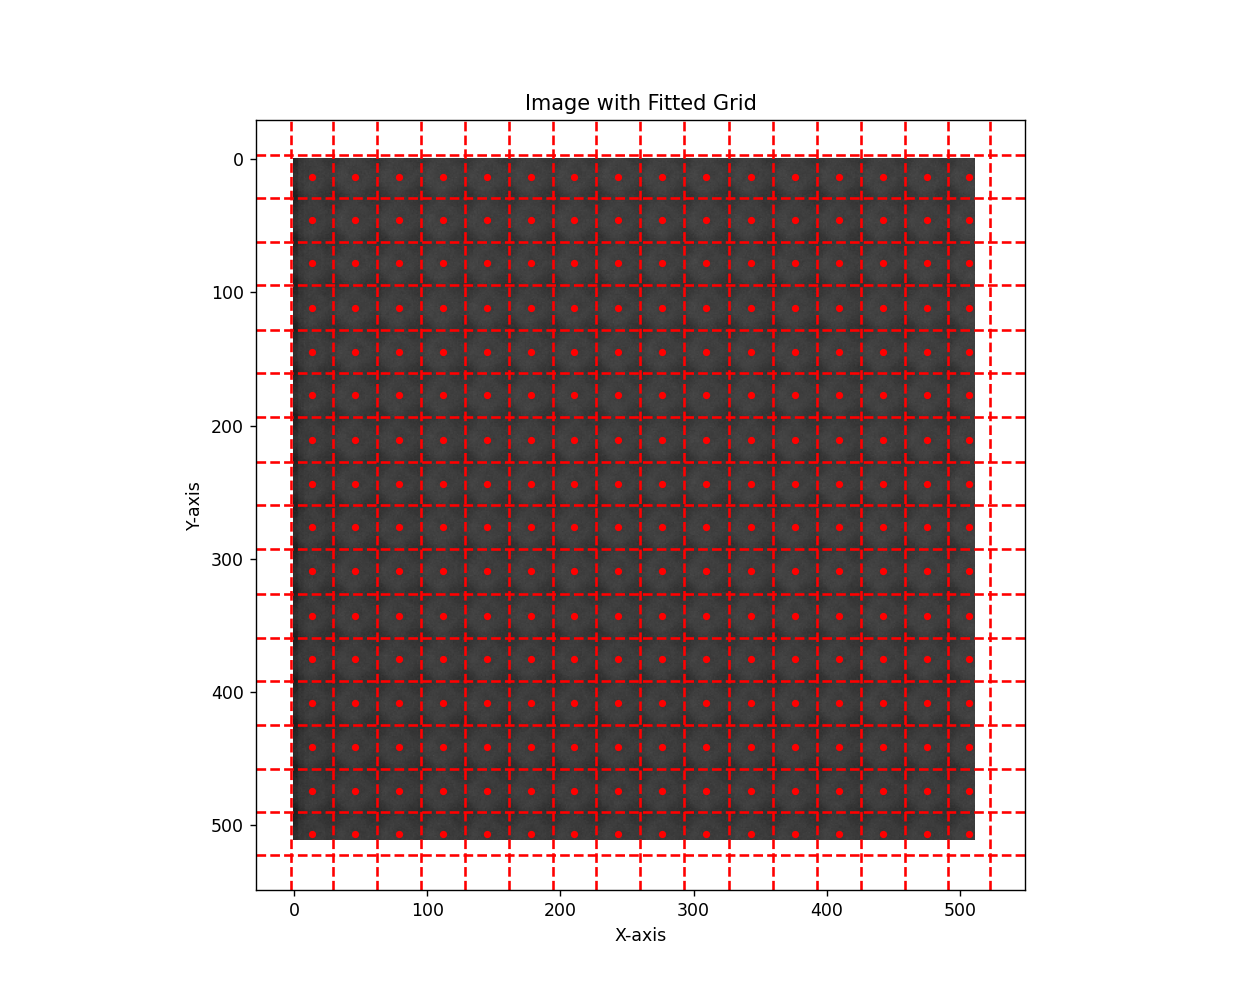

In [8]:
calibrate(im)

Mean Diameter: 33.333333333333336
Grid X Position: [-11.75  15.75  46.5   80.   113.75 147.75 181.5  215.25 249.25 283.25
 317.   351.   385.   418.75 452.25 485.5  518.5 ]
Grid Y Position: [-14.5   16.5   48.75  82.   115.75 149.75 183.75 217.5  251.   285.
 319.   353.25 387.25 421.   454.75 486.25 515.75]


<IPython.core.display.Javascript object>


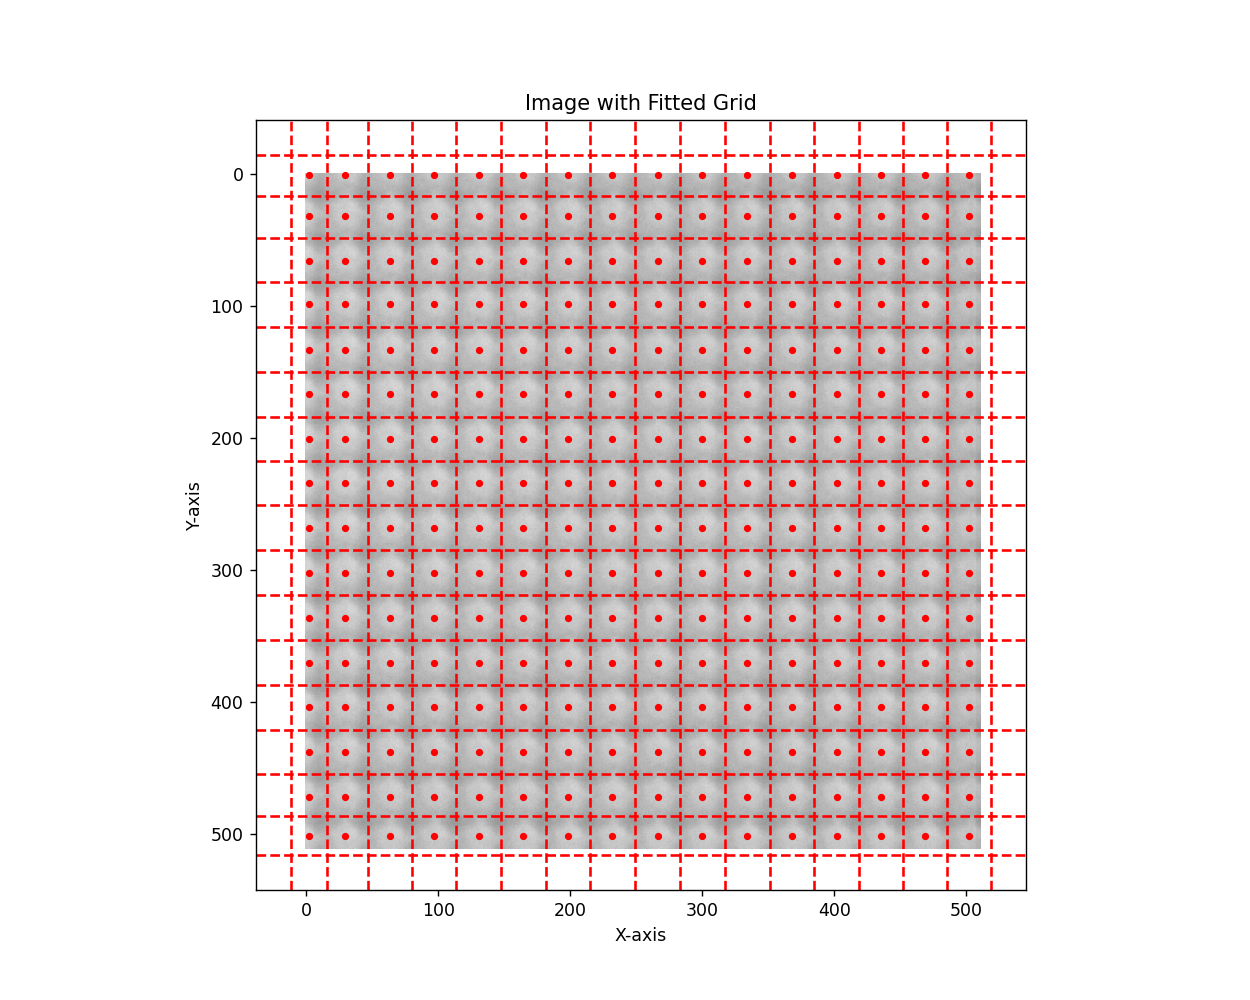

In [9]:
im2 = cv2.imread("../img/pcv_image_calibration_medium_exposure.png")
#histogram(im2)
calibrate(im2)

# SVD Method

In [65]:
# Pre-Processsing
gray = im[:,:,0]
gray = cv2.GaussianBlur(gray, (15, 15), 0)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 3)

# Get circle coordinates. The circles are sorted by y position.
circles = get_circles(thresh)
nb_x, nb_y = count_peaks(thresh, 0), count_peaks(thresh, 1)
# Construct matrix B of the equation AX = B
B = []
for c in circles:
    B.append(c[0])
    B.append(c[1])
B = np.array(B).reshape(-1,1)

# Construct matrix A of the equation
A = np.zeros((len(circles)*2, 4))

i = 0
jx, jy = 0, 0
while i < A.shape[0]:
    row = A[i]
    if i % 2 == 0:
        if jx % nb_x == 0 and jx != 0:
            jy += 1
            jx = 0
        # Row about a x-coordinate
        row[:] = [1, 0, 0, 0]
        row[2] = jx
        jx += 1
    else:
        if jy % nb_y == 0:
            jy = 0
        # Row about y-coordinate
        row[:] = [0, 1, 0, 0]
        row[3] = jy
    i += 1     
        
# Find SVD of A
U, S, Vt = np.linalg.svd(A, full_matrices=False)
# Compute the pseudo-inverse of S
S_inv = np.diag(1 / S)
# Solve for X using SVD components
cx_0, cy_0, dx, dy = Vt.T @ S_inv @ U.T @ B
print(cx_0,cy_0, dx, dy)

[260.25] [259.9375] [5.68125604e-14] [2.62916858e-14]
